## 0. Imports & functions

In [1]:
#imports 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import random
% matplotlib inline

import sklearn
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
import sklearn.cross_validation as cv
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
from sklearn.metrics import confusion_matrix


import warnings
warnings.filterwarnings('ignore')

/Users/alicemartin/miniconda3/envs/project/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/Users/alicemartin/miniconda3/envs/project/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 1. Data Processing

In [42]:
def patients_selection(df, threshold=6):
    '''return a dataframe containing only the patients with number of visits > threshold'''
    if 'PATNO' in df.columns: 
        visits_number_by_pat=df.groupby('PATNO').size().sort_values(ascending=False)
        mask_sel=visits_number_by_pat>=threshold
        patients_sel=list(mask_sel[mask_sel.values==True].index)
        df=df.loc[df['PATNO'].isin(patients_sel),:]
        df=df.sort_values('PATNO')
        return (patients_sel, df)
    else:
        return 0

file_path='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/output/pre-processing/dfFinal.csv'
df2=pd.read_csv(file_path)

df_th2=patients_selection(df,threshold=2)[1]
print('samples lost: {}'.format((df2.shape[0]-df_th2.shape[0])))
print(df_th2.shape)
df_th2['num_visits'].value_counts()

samples lost: 671
(4113, 376)


6    852
7    714
2    586
3    564
5    525
4    512
8    360
Name: num_visits, dtype: int64

### padding for patients with visits <4

In [44]:
# padding rows for num_visits <4 

rowstoAdd=df_th2[df_th2['num_visits']==2].groupby('PATNO').median()
rowstoAdd['VISIT_ID']=3
rowstoAdd['visitsdiff_days']=3*61
rowstoAdd['lastDate_diff_days']=rowstoAdd['lastDate_diff_days']-rowstoAdd['visitsdiff_days']
rowstoAdd['PDDXDT_diff_days']=rowstoAdd['PDDXDT_diff_days'].where(rowstoAdd['PDDXDT_diff_days']==0,
                                                                 rowstoAdd['PDDXDT_diff_days']+rowstoAdd['visitsdiff_days'])
maskMED=rowstoAdd['PDMEDT_diff_days']!=0
rowstoAdd.loc[maskMED,'PDMEDT_diff_days']=rowstoAdd.loc[maskMED,'PDMEDT_diff_days']+rowstoAdd.loc[maskMED,'visitsdiff_days']
maskSURG=rowstoAdd['PDSURGDT_diff_days']!=0
rowstoAdd.loc[maskSURG,'PDSURGDT_diff_days']=rowstoAdd.loc[maskSURG,'PDSURGDT_diff_days']+rowstoAdd.loc[maskSURG,'visitsdiff_days']

rowstoAdd2=df_th2[df_th2['num_visits']==2].groupby('PATNO').median()
rowstoAdd2['VISIT_ID']=4
rowstoAdd2['visitsdiff_days']=3*61
rowstoAdd2['lastDate_diff_days']=rowstoAdd2['lastDate_diff_days']-rowstoAdd2['visitsdiff_days']
rowstoAdd2['PDDXDT_diff_days']=rowstoAdd2['PDDXDT_diff_days'].where(rowstoAdd2['PDDXDT_diff_days']==0,
                                                                 rowstoAdd2['PDDXDT_diff_days']+rowstoAdd2['visitsdiff_days'])

rowstoAdd2.loc[maskMED,'PDMEDT_diff_days']=rowstoAdd2.loc[maskMED,'PDMEDT_diff_days']+rowstoAdd2.loc[maskMED,'visitsdiff_days']
rowstoAdd2.loc[maskSURG,'PDSURGDT_diff_days']=rowstoAdd2.loc[maskSURG,'PDSURGDT_diff_days']+rowstoAdd2.loc[maskSURG,'visitsdiff_days']


rows3toAdd=df_th2[df_th2['num_visits']==3].groupby('PATNO').median()
rows3toAdd['VISIT_ID']=4
rows3toAdd['visitsdiff_days']=3*61
rows3toAdd['lastDate_diff_days']=rows3toAdd['lastDate_diff_days']-rows3toAdd['visitsdiff_days']
rows3toAdd['PDDXDT_diff_days']=rows3toAdd['PDDXDT_diff_days'].where(rows3toAdd['PDDXDT_diff_days']==0,
                                                                 rows3toAdd['PDDXDT_diff_days']+rows3toAdd['visitsdiff_days'])
mask3MED=rows3toAdd['PDMEDT_diff_days']!=0
rows3toAdd.loc[mask3MED,'PDMEDT_diff_days']=rows3toAdd.loc[mask3MED,'PDMEDT_diff_days']+rows3toAdd.loc[mask3MED,'visitsdiff_days']
mask3SURG=rows3toAdd['PDSURGDT_diff_days']!=0
rows3toAdd.loc[mask3SURG,'PDSURGDT_diff_days']=rows3toAdd.loc[mask3SURG,'PDSURGDT_diff_days']+rows3toAdd.loc[mask3SURG,'visitsdiff_days']

rowspadding=pd.concat([rowstoAdd,rowstoAdd2,rows3toAdd])
rowspadding['num_visits']=4
rowspadding.reset_index(inplace=True)
print(rowspadding.shape)

# reformatting final df
dfpad_th4=df_th2.drop(columns='INFODT_date')
print(dfpad_th4.shape)
dfpad_th4=pd.concat([dfpad_th4,rowspadding])
print(dfpad_th4.shape)
dfpad_th4['num_visits'].replace(2,4,inplace=True)
dfpad_th4['num_visits'].replace(3,4,inplace=True)
dfpad_th4.reset_index(drop=True,inplace=True)
dfpad_th4.head()
print((len(rowstoAdd),len(rows3toAdd)))
dfpad_th4['NHY']=dfpad_th4['NHY'].apply(lambda x: round(x,0))
dfpad_th4.sort_values(['PATNO','VISIT_ID'],inplace=True)
print(dfpad_th4.shape)

# creating data & target from final df
datatoDrop=dfpad_th4[dfpad_th4['num_visits']==dfpad_th4['VISIT_ID']]
print(datatoDrop.shape)
data_TS=dfpad_th4.drop(index=list(datatoDrop.index),columns=['MSEADLG'])
data_TS.set_index(keys=['PATNO'],inplace=True)
print(data_TS.shape)

targettoDrop=dfpad_th4[dfpad_th4['VISIT_ID']==1]
print(targettoDrop.shape)
target_TS=dfpad_th4.drop(index=list(targettoDrop.index))
target_TS.set_index(keys=['PATNO'],inplace=True)
assert len(target_TS)==len(data_TS)
assert set(data_TS.index)==set(target_TS.index)
target_TS=target_TS['NHY']
print(target_TS.shape)
list(set(target_TS.values))

(774, 375)
(4113, 375)
(4887, 375)
(293, 188)
(4887, 375)
(1003, 375)
(3884, 373)
(1003, 375)
(3884,)


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0]

## Training ML models (Logistic Regression, RandomForest, XGBoost)

### custom train/test split for time-series data

In [45]:
print(round(0.2*len(set(data_TS.index)),0))
np.random.seed(123)
pat_testset=np.random.choice(list(set(data_TS.index)),201,replace=False)
X_test=data_TS.loc[pat_testset,:]
X_test.head(50)
print(X_test.shape)
X_train=data_TS.drop(index=pat_testset)
print(X_train.shape)
y_test=target_TS[pat_testset]
print(y_test.shape)
assert set(y_test.index)==set(X_test.index)
y_train=target_TS.drop(index=pat_testset)
print(y_train.shape)
assert set(y_train.index)==set(X_train.index)

201.0
(787, 373)
(3097, 373)
(787,)
(3097,)


### Models training (Dummy, Logistic Regression, RF, XGBoost)

In [46]:
from sklearn.dummy import DummyClassifier
dummy=DummyClassifier()
dummy.fit(X_train, y_train)

#### Logistic Regression
from sklearn.linear_model import LogisticRegression
logreg_TS = LogisticRegression(multi_class='multinomial',solver='newton-cg',random_state=0,max_iter=500)
logreg_TS.fit(X_train, y_train)

#### Random Forest
rfc_TS = RandomForestClassifier(n_estimators=100, random_state=0,n_jobs=-1)
rfc_TS.fit(X_train, y_train)

#### XGBoost
from xgboost import XGBClassifier
xgb_TS = XGBClassifier(n_jobs=-1,seed=0)
xgb_TS.fit(X_train, y_train)

/Users/alicemartin/miniconda3/envs/project/lib/python3.5/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=1)

In [47]:
print("Train-Score-dummy: %.4f, Test-Accuracy-dummy: %.4f" % (dummy.score(X_train, y_train), dummy.score(X_test, y_test)))

print("Train-Score-logreg: %.4f, Test-Accuracy-logreg: %.4f" % (logreg_TS.score(X_train, y_train), logreg_TS.score(X_test, y_test)))
print("Train-Score-rfc: %.4f, Test-Accuracy-rfc: %.4f" % (rfc_TS.score(X_train, y_train), rfc_TS.score(X_test, y_test)))
print("Train-Score-xgb: %.2f, Test-Accuracy-xgb: %.2f" % (xgb_TS.score(X_train, y_train), 
                                                          xgb_TS.score(X_test, y_test)))

Train-Score-dummy: 0.3807, Test-Accuracy-dummy: 0.4193
Train-Score-logreg: 0.8802, Test-Accuracy-logreg: 0.7789
Train-Score-rfc: 1.0000, Test-Accuracy-rfc: 0.8094
Train-Score-xgb: 0.89, Test-Accuracy-xgb: 0.82


## 3. Cross-Validation

In [48]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.model_selection import cross_val_score
# C = 1/lambda, the parameter of the sigmoid function
# lambda = 0.001, 0.005, 0.01, 0.05, ..., 1, 5, 10, 50
cv_score_rfc=cross_val_score(rfc_TS,data_TS,target_TS,cv=5,n_jobs=-1)
cv_score_xgb=cross_val_score(xgb_TS,data_TS,target_TS,cv=5,n_jobs=-1)
cv_score_lr=cross_val_score(logreg_TS,data_TS,target_TS,cv=5,n_jobs=-1)

[0.75609756 0.79150579 0.79021879 0.79021879 0.75968992]
0.7775461710799203


In [56]:
from sklearn.model_selection import cross_validate

In [57]:
cross_validate_rfc=cross_validate(rfc_TS,data_TS,target_TS,cv=5,n_jobs=-1,return_train_score=True)
cross_validate_xgb=cross_validate(xgb_TS,data_TS,target_TS,cv=5,n_jobs=-1,return_train_score=True)
cross_validate_lr=cross_validate(logreg_TS,data_TS,target_TS,cv=5,n_jobs=-1,return_train_score=True)

/Users/alicemartin/miniconda3/envs/project/lib/python3.5/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/alicemartin/miniconda3/envs/project/lib/python3.5/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/alicemartin/miniconda3/envs/project/lib/python3.5/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/alicemartin/miniconda3/envs/project/lib/python3.5/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/alicemartin/miniconda3/envs/project/lib/python3.5/site-pa

In [55]:
print('cv score LR:{}'.format((cv_score_lr,cv_score_lr.mean())))
print('cv score RF:{}'.format((cv_score_rfc,cv_score_rfc.mean())))
print('cv score XGB:{}'.format((cv_score_xgb,cv_score_xgb.mean())))

cv score LR:(array([0.67265725, 0.74517375, 0.72715573, 0.73745174, 0.63824289]), 0.7041362713452752)
cv score RF:(array([0.75609756, 0.79150579, 0.79021879, 0.79021879, 0.75968992]), 0.7775461710799203)
cv score XGB:(array([0.7406932 , 0.78120978, 0.79021879, 0.83140283, 0.76356589]), 0.7814180981419839)


In [61]:
#print(cross_validate_lr)
print("Training Accuracy LR: %0.2f (+/- %0.2f)" % (cross_validate_lr['train_score'].mean(), cross_validate_lr['train_score'].std() * 2))
print("Training Accuracy RF: %0.2f (+/- %0.2f)" % (cross_validate_rfc['train_score'].mean(), cross_validate_rfc['train_score'].std() * 2))
print("Training Accuracy XGB: %0.2f (+/- %0.2f)" % (cross_validate_xgb['train_score'].mean(), cross_validate_xgb['train_score'].std() * 2))

print("Test Accuracy LR: %0.2f (+/- %0.2f)" % (cross_validate_lr['test_score'].mean(), cross_validate_lr['test_score'].std() * 2))
print("Test Accuracy RF: %0.2f (+/- %0.2f)" % (cross_validate_rfc['test_score'].mean(), cross_validate_rfc['test_score'].std() * 2))
print("Test Accuracy XGB: %0.2f (+/- %0.2f)" % (cross_validate_xgb['test_score'].mean(), cross_validate_xgb['test_score'].std() * 2))

Training Accuracy LR: 0.89 (+/- 0.01)
Training Accuracy RF: 1.00 (+/- 0.00)
Training Accuracy XGB: 0.89 (+/- 0.01)
Test Accuracy LR: 0.70 (+/- 0.08)
Test Accuracy RF: 0.78 (+/- 0.03)
Test Accuracy XGB: 0.78 (+/- 0.06)


### Features importance: to compare with simple classification problem

In [219]:
feature_importances = pd.DataFrame(rfc_TS.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
ImportantFeatures_TS=feature_importances[feature_importances.values>=0.01]
print(ImportantFeatures_TS.values.sum())
RelevantFeatures=feature_importances[feature_importances.values> 0]
assert RelevantFeatures.values.sum()==1
ImportantFeatures_TS=ImportantFeatures_TS*100
ImportantFeatures_TS

0.4054402725052078


,importance
NHY,7.853733
PDDXDT_diff_days,4.409014
DOMSIDE,2.941035
DFBRADYP,2.862482
DFRIGIDP,2.275013
PRIMDIAG,2.129814
APPRDX,1.933023
NP3FACXP,1.619591
NP3BRADY,1.556028
DFBRADYA,1.448058


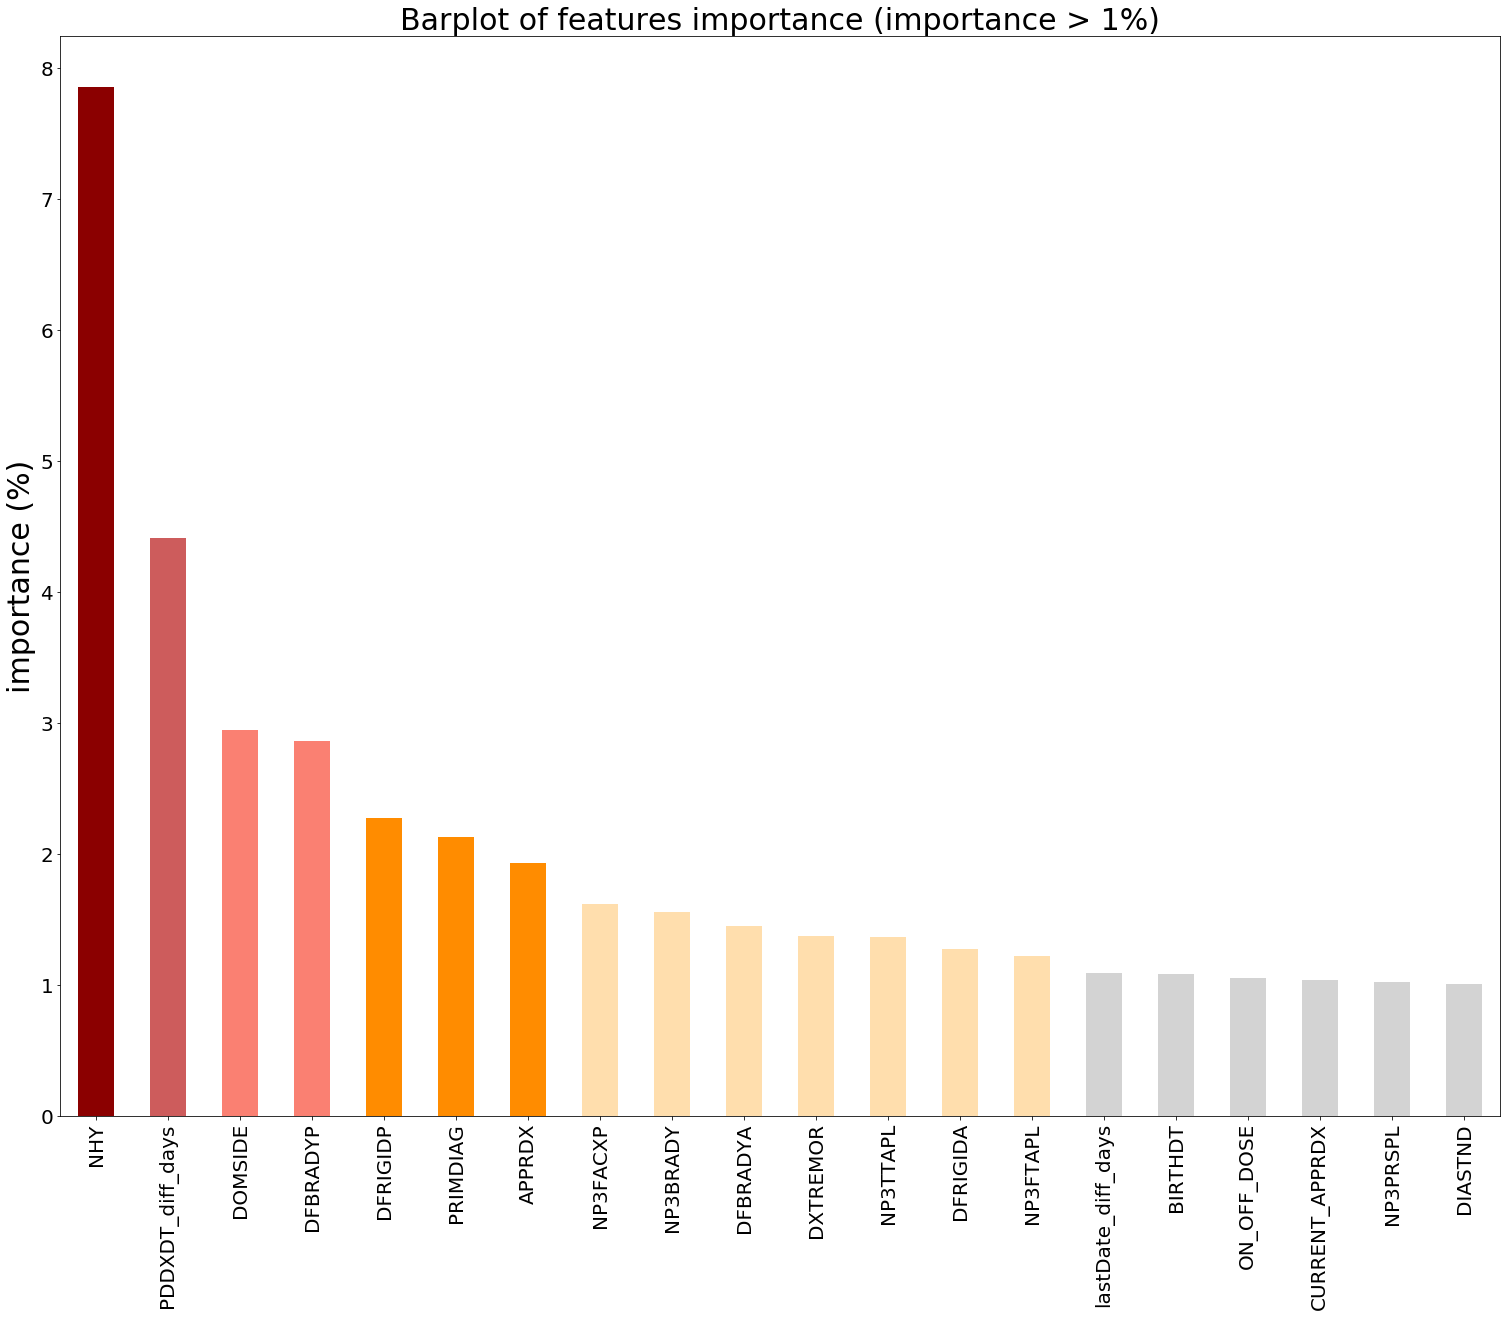

In [257]:
#fig,ax=plt.figure()
#ax=fig.add_axes([1,1,1,1])
colors1=['darkred','indianred']
colors2=['salmon'] * 2
colors3=['darkorange']*3
colors4=['navajowhite']*7
colors5=['lightgray']*6

import itertools

colors=list(itertools.chain(colors1,colors2,colors3,colors4,colors5))
fig=plt.figure(figsize=(20,15))
ax=fig.add_axes([1,1,1,1])
bar_features=ImportantFeatures_TS.plot(y='importance',kind='bar',
                                       fontsize=20,color=colors,legend=False,ax=ax)
ax.set_title('Barplot of features importance (importance > 1%)',fontdict={'fontsize':30})
ax.set_ylabel(ylabel='importance (%)',fontdict={'fontsize':30})
fig.savefig('/Users/alicemartin/02_DSR_Project/parkinson-disease-project/output/ML_predictions/featuresImportance.png')
plt.show()

In [75]:
def plot_importantFeatures(clf,X_train,threshold=0.01,figsize=(10,10),color='b'):
    importances=clf.feature_importances_
    importances=importances[importances>=threshold]
    features = X_train.columns
    indices = np.argsort(importances)
    fig = plt.figure(figsize=figsize)
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color=color, align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

In [209]:
#plot_importantFeatures(rfc_TS,X_train,color='green')
# TO CORRECT!!!!

### GridSearchCV on RandomForestClassifier

In [83]:
data_GS=data_TS[RelevantFeatures.index]
assert len(data_GS)==len(target_TS)
data_GS.head()

,NHY,PDDXDT_diff_days,DOMSIDE,DFBRADYP,DFRIGIDP,PRIMDIAG,APPRDX,NP3FACXP,NP3BRADY,DFBRADYA,...,DFCHOREA,DFHEMPRK,PDMEDT_diff_days,DFMYOCLO,MCACAMEL,NARCLPSY,MHROW_9,MHROW_11,DFAGESX,MHROW_10
PATNO,,,,,,,,,,,,,,,,,,,,,
3001,2.0,306.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3001,2.0,700.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3001,2.0,1126.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3001,2.0,1461.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3001,2.0,1826.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [86]:
np.mean([estimator.tree_.max_depth for estimator in rfc_TS.estimators_])

27.59

In [87]:
def grid_search(param_grid, estimator, data, target, cv=3,njobs=-1):
    from sklearn.model_selection import GridSearchCV
    est = estimator
    grid_search=GridSearchCV(est, param_grid,cv=cv)
    grid_search.fit(data,target)
    print("Best estimator:\n{}".format(grid_search.best_estimator_))
    print("Best parameters: {}".format(grid_search.best_params_))
    print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
    return grid_search

In [167]:
param_grid_rfc={'n_estimators':[250,500],
               'max_features':[10,20,30],
               'max_depth':[None,10,20]}
grid_search1=grid_search(param_grid_rfc, estimator=RandomForestClassifier(random_state=0), 
                         data=data_GS, target=target_TS)

#grid_search1.cv_results_

Best estimator:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
Best parameters: {'max_depth': 10, 'n_estimators': 250, 'max_features': 10}
Best cross-validation score: 0.75


In [168]:
# it seems that the overfitting can be really reduced by playing on max_depth: remove None option
param_grid4_rfc={'n_estimators':[250],
               'max_features':[5,10,15,17],
               'max_depth':[5,10,15,17]}
grid_search2=grid_search(param_grid4_rfc, estimator=RandomForestClassifier(random_state=0), data=data_GS, target=target_TS)
#grid_search2.cv_results_

Best estimator:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
Best parameters: {'max_depth': 5, 'n_estimators': 250, 'max_features': 5}
Best cross-validation score: 0.76


In [169]:
param_grid_rfc3={'n_estimators':[250],
               'max_features':[1,5,7,10,12],
               'max_depth':[1,5,7,10,12]}
grid_search3=grid_search(param_grid_rfc3, estimator=RandomForestClassifier(random_state=0), 
                         data=data_GS, target=target_TS)

Best estimator:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features=12, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
Best parameters: {'max_depth': 7, 'n_estimators': 250, 'max_features': 12}
Best cross-validation score: 0.76


### Plotting the bias/variance tradeoff

In [170]:
GS1_test_score=grid_search1.cv_results_['mean_test_score']
GS1_train_score=grid_search1.cv_results_['mean_train_score']
GS1_params=grid_search1.cv_results_['params']
GS2_test_score=grid_search2.cv_results_['mean_test_score']
GS2_train_score=grid_search2.cv_results_['mean_train_score']
GS2_params=grid_search2.cv_results_['params']
GS3_test_score=grid_search3.cv_results_['mean_test_score']
GS3_train_score=grid_search3.cv_results_['mean_train_score']
GS3_params=grid_search3.cv_results_['params']

#### Max_features as variable

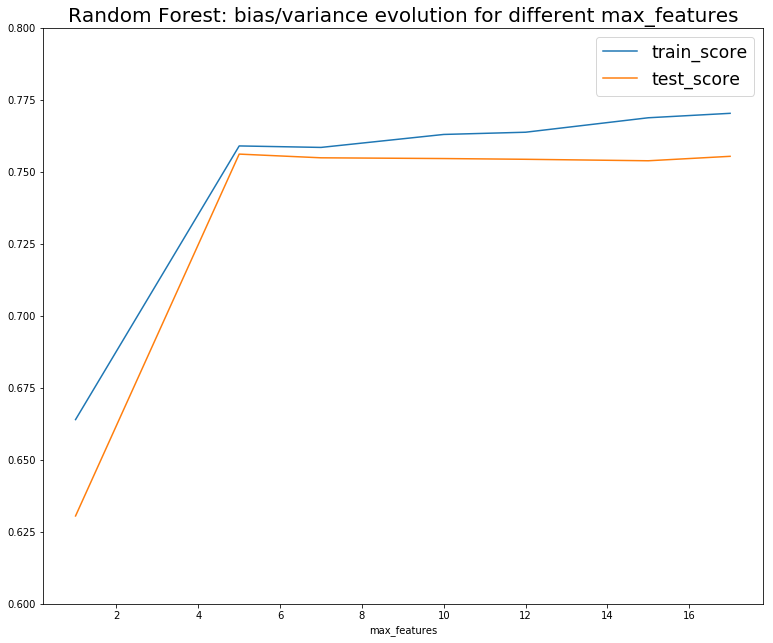

In [244]:
serGS1_train=pd.Series(GS1_train_score)
serGS1_test=pd.Series(GS1_test_score)
dfGS1=pd.DataFrame(GS1_params)
dfGS1=pd.concat([serGS1_train,serGS1_test,dfGS1],axis=1)
dfGS1.rename(columns={0:'train_score',1:'test_score'},inplace=True)
serGS2_train=pd.Series(GS2_train_score)
serGS2_test=pd.Series(GS2_test_score)
dfGS2=pd.DataFrame(GS2_params)
dfGS2=pd.concat([serGS2_train,serGS2_test,dfGS2],axis=1)
dfGS2.rename(columns={0:'train_score',1:'test_score'},inplace=True)

serGS3_train=pd.Series(GS3_train_score)
serGS3_test=pd.Series(GS3_test_score)
dfGS3=pd.DataFrame(GS3_params)
dfGS3=pd.concat([serGS3_train,serGS3_test,dfGS3],axis=1)
dfGS3.rename(columns={0:'train_score',1:'test_score'},inplace=True)


dfGS=pd.concat([dfGS2,dfGS3])
#dfGS_toplot=dfGS[dfGS['n_estimators']==250]
dfGS_toplot=dfGS[dfGS['max_depth']==5]
dfGS_toplot.drop(index=[6],inplace=True)
dfGS_toplot.sort_values('max_features',inplace=True)

fig= plt.figure(figsize=(10,8))
ax=fig.add_axes([1,1,1,1])
plot_maxdepth=dfGS_toplot.plot(x='max_features',y=['train_score','test_score'],ylim=[0.6,0.8],ax=ax)
ax.legend(fontsize='xx-large')
ax.set_title('Random Forest: bias/variance evolution for different max_features',fontdict={'fontsize':20})
fig.savefig('/Users/alicemartin/02_DSR_Project/parkinson-disease-project/output/ML_predictions/bias_variance_maxFeatures.png')
plt.show()

#### Max_depth as variable

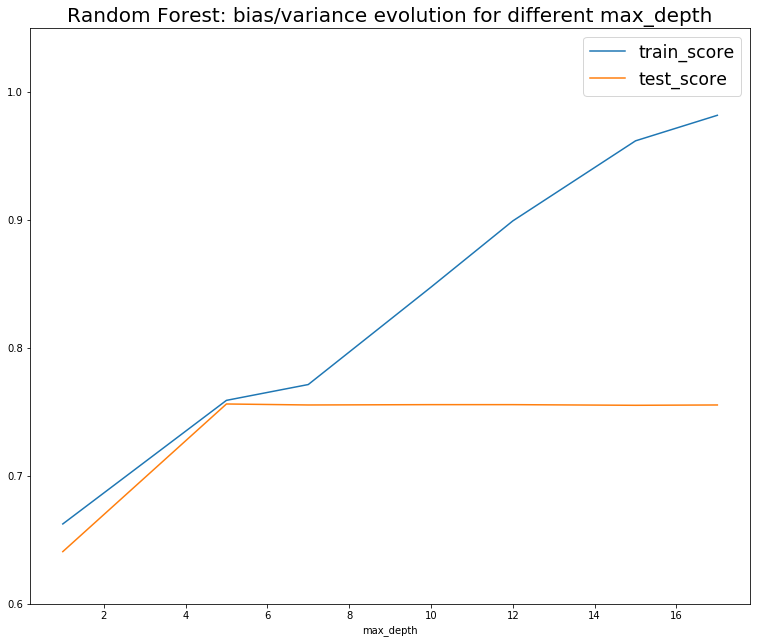

In [208]:
dfGS_maxdepth=dfGS[dfGS['max_features']==5]
dfGS_maxdepth.drop(index=[6,16],inplace=True)
dfGS_maxdepth.sort_values('max_depth',inplace=True)
#dfGS_maxdepth['max_depth']=dfGS_maxdepth['max_depth'].replace(np.nan,100)

fig= plt.figure(figsize=(10,8))
ax=fig.add_axes([1,1,1,1])
dfGS_maxdepth.plot(x='max_depth',y=['train_score','test_score'],ylim=[0.6,1.05],ax=ax)
ax.legend(fontsize='xx-large')
ax.set_title('Random Forest: bias/variance evolution for different max_depth',fontdict={'fontsize':20})
#plt.close()
fig.savefig('/Users/alicemartin/02_DSR_Project/parkinson-disease-project/output/ML_predictions/bias_variance_maxdepth.png')

In [137]:
rfc_final=RandomForestClassifier(max_depth=5,max_features=5,n_estimators=250, random_state=0,n_jobs=-1)

In [134]:
from sklearn.ensemble import VotingClassifier

eclf1 = VotingClassifier(estimators=[('LogReg',logreg_TS), ('rfc', rfc_TS), ('xgb', xgb_TS)], voting='hard')
eclf2 = VotingClassifier(estimators=[('LogReg',logreg_TS), ('rfc', rfc_TS), ('xgb', xgb_TS)], voting='soft', 
                         weights=[1,1,2])
eclf3 = VotingClassifier(estimators=[('LogReg',logreg_TS), ('rfc', rfc_TS), ('xgb', xgb_TS)], voting='soft')


eclf1.fit(X_train,y_train)
eclf2.fit(X_train,y_train)
eclf3.fit(X_train,y_train)

/Users/alicemartin/miniconda3/envs/project/lib/python3.5/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/alicemartin/miniconda3/envs/project/lib/python3.5/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/alicemartin/miniconda3/envs/project/lib/python3.5/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


VotingClassifier(estimators=[('LogReg', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=0, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)), ('rfc...=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=1))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [142]:
eclf4= VotingClassifier(estimators=[('LogReg',logreg_TS), ('rfc', rfc_TS), ('xgb', xgb_TS)], voting='soft', 
                         weights=[1,2,2])
eclf4.fit(X_train,y_train)

/Users/alicemartin/miniconda3/envs/project/lib/python3.5/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


VotingClassifier(estimators=[('LogReg', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=0, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)), ('rfc...=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=1))],
         flatten_transform=None, n_jobs=1, voting='soft',
         weights=[1, 2, 2])

In [135]:
for clf, label in zip([logreg_TS, rfc_TS, xgb_TS, eclf1, eclf3, eclf2], ['Logistic Regression', 'Random Forest', 
                                                                         'XGBoost', 
                                                                         'Ensemble - Hard Voting',
                                                                         'Ensemble-soft Voting',
                                                                         'Ensemble-Soft Voting weighted']):
    score= (clf.score(X_train, y_train),clf.score(X_test, y_test))
    print(label+'{}'.format(score))

Logistic Regression(0.880206651598321, 0.7789072426937739)
Random Forest(1.0, 0.8094027954256671)
XGBoost(0.8895705521472392, 0.818297331639136)
Ensemble - Hard Voting(0.9257345818534065, 0.818297331639136)
Ensemble-soft Voting(0.9389731998708427, 0.8195679796696315)
Ensemble-Soft Voting weighted(0.9276719405876654, 0.8259212198221093)


In [145]:
print('Ensemble-Soft Voting weights=[1,2,2]:{}'.format((eclf4.score(X_train, y_train),eclf4.score(X_test, y_test))))

Ensemble-Soft Voting weights=[1,2,2]:(0.9451081691959962, 0.818297331639136)


In [146]:
eclf5 = VotingClassifier(estimators=[('LogReg',logreg_TS), ('rfc', rfc_final), ('xgb', xgb_TS)], voting='hard')
eclf6 = VotingClassifier(estimators=[('LogReg',logreg_TS), ('rfc', rfc_final), ('xgb', xgb_TS)], voting='soft', 
                         weights=[1,1,2])
eclf7 = VotingClassifier(estimators=[('LogReg',logreg_TS), ('rfc', rfc_final), ('xgb', xgb_TS)], voting='soft')
eclf8 = VotingClassifier(estimators=[('LogReg',logreg_TS), ('rfc', rfc_final), ('xgb', xgb_TS)], voting='soft', 
                         weights=[1,2,2])
eclf5.fit(X_train,y_train)
eclf6.fit(X_train,y_train)
eclf7.fit(X_train,y_train)
eclf8.fit(X_train,y_train)

/Users/alicemartin/miniconda3/envs/project/lib/python3.5/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/alicemartin/miniconda3/envs/project/lib/python3.5/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/alicemartin/miniconda3/envs/project/lib/python3.5/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/alicemartin/miniconda3/envs/project/lib/python3.5/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


VotingClassifier(estimators=[('LogReg', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=0, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)), ('rfc...=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=1))],
         flatten_transform=None, n_jobs=1, voting='soft',
         weights=[1, 2, 2])

In [147]:
for clf, label in zip([logreg_TS, rfc_TS, xgb_TS, eclf5, eclf6, eclf7, eclf8], ['Logistic Regression', 'Random Forest', 
                                                                         'XGBoost', 
                                                                         'Ensemble - Hard Voting',
                                                                         'Ensemble-soft Voting',
                                                                         'Ensemble-Soft Voting weights=[1,1,2]',
                                                                        'Ensemble-Soft Voting weights=[1,2,2]']):
    score= (clf.score(X_train, y_train),clf.score(X_test, y_test))
    print(label+'{}'.format(score))

Logistic Regression(0.880206651598321, 0.7789072426937739)
Random Forest(1.0, 0.8094027954256671)
XGBoost(0.8895705521472392, 0.818297331639136)
Ensemble - Hard Voting(0.8779463997416855, 0.8144853875476493)
Ensemble-soft Voting(0.8834355828220859, 0.8221092757306226)
Ensemble-Soft Voting weights=[1,1,2](0.878915079108815, 0.8132147395171537)
Ensemble-Soft Voting weights=[1,2,2](0.8731030029060382, 0.8170266836086404)


In [148]:
eclf9 = VotingClassifier(estimators=[('LogReg',logreg_TS), ('rfc', rfc_final), ('xgb', xgb_TS)], voting='soft', 
                         weights=[1,2,1])
eclf9.fit(X_train,y_train)

/Users/alicemartin/miniconda3/envs/project/lib/python3.5/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


VotingClassifier(estimators=[('LogReg', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=0, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)), ('rfc...=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=1))],
         flatten_transform=None, n_jobs=1, voting='soft',
         weights=[1, 2, 1])

In [149]:
print('Ensemble-Soft Voting weights=[1,2,1]:{}'.format((eclf9.score(X_train, y_train),eclf9.score(X_test, y_test))))

Ensemble-Soft Voting weights=[1,2,1]:(0.8582499192767195, 0.8106734434561627)


### CV on eclf3, eclf9

In [152]:
cross_validate_ecfl3=cross_validate(eclf3,data_TS,target_TS,cv=3,n_jobs=-1,return_train_score=True)
cross_validate_ecfl9=cross_validate(eclf9,data_TS,target_TS,cv=3,n_jobs=-1,return_train_score=True)

/Users/alicemartin/miniconda3/envs/project/lib/python3.5/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/alicemartin/miniconda3/envs/project/lib/python3.5/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/alicemartin/miniconda3/envs/project/lib/python3.5/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/alicemartin/miniconda3/envs/project/lib/python3.5/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/alicemartin/miniconda3/envs/project/lib/python3.5/site-pa

In [154]:
print("Training Accuracy eclf3: %0.2f (+/- %0.2f)" % (cross_validate_ecfl3['train_score'].mean(), cross_validate_ecfl3['train_score'].std() * 2))
print("Training Accuracy eclf9: %0.2f (+/- %0.2f)" % (cross_validate_ecfl9['train_score'].mean(), cross_validate_ecfl9['train_score'].std() * 2))

print("Test Accuracy eclf3: %0.2f (+/- %0.2f)" % (cross_validate_ecfl3['test_score'].mean(), cross_validate_ecfl3['test_score'].std() * 2))
print("Test Accuracy eclf9: %0.2f (+/- %0.2f)" % (cross_validate_ecfl9['test_score'].mean(), cross_validate_ecfl9['test_score'].std() * 2))

Training Accuracy eclf3: 0.90 (+/- 0.01)
Training Accuracy eclf9: 0.87 (+/- 0.02)
Test Accuracy eclf3: 0.67 (+/- 0.29)
Test Accuracy eclf9: 0.69 (+/- 0.23)


### PLotting the results. 

In [ ]:
y_pred_logreg=logreg_TS.predict(X_test)
predictions_logreg=pd.Series(y_pred_logreg,index=y_test.index)

y_test_pred_logreg=pd.concat([y_test,predictions_logreg],axis=1)
y_test_pred_logreg.rename(columns={'NHY':'trueLabel',0:'prediction_logreg'},inplace=True)

VISIT_ID=[2]
for i in range(1,len(y_test_pred_logreg)):
    if (y_test_pred_logreg.index[i]==y_test_pred_logreg.index[i-1]):
        visit=VISIT_ID[len(VISIT_ID)-1]+1
    else:
        visit=2
    VISIT_ID.append(visit)
print(len(VISIT_ID))
y_test_pred_logreg['VISIT_ID_future']=VISIT_ID

y_pred_rfc=pd.Series(rfc_TS.predict(X_test),index=y_test.index)
y_pred_rfc.name='prediction_rfc'
y_pred_xgb=pd.Series(xgb_TS.predict(X_test),index=y_test.index)
y_pred_xgb.name='prediction_xgb'

test_all=pd.concat([X_test,y_test_pred_logreg, y_pred_rfc,y_pred_xgb],axis=1)
print(len(test_all))
results_toplot=test_all[['num_visits','VISIT_ID','NHY','VISIT_ID_future','trueLabel',
                         'prediction_logreg','prediction_rfc','prediction_xgb']]
results_toplot.reset_index(inplace=True)
results_toplot.head()

In [ ]:
def patients_sampling(df,sample_size=25,seed=123):
    np.random.seed(seed)
    sample=list(np.random.randint(0,len(set(df['PATNO'])),sample_size+1))
    patients_sample=pd.Series(list(set(df['PATNO'])))[sample]
    patients_sample=list(patients_sample.values)
    sub_df=df.loc[df['PATNO'].isin(patients_sample),:]
    return sub_df
df_toPlot=patients_sampling(results_toplot)

fig = plt.figure(figsize=(60,60))
num_pat=len(set(df_toPlot['PATNO']))
for pat,num in zip(list(set(df_toPlot['PATNO'])),range(1,num_pat+1)):
    df0=df_toPlot[df_toPlot['PATNO']==pat]
    ax = fig.add_subplot(5,5,num)
    ax.plot(df0['VISIT_ID'], df0['NHY'],marker='o', markerfacecolor='blue', markersize=15, 
            color='skyblue', linewidth=4,label='NHY history')
    ax.plot(df0['VISIT_ID_future'], df0['trueLabel'],marker='o',markersize=15,
            color='blue',linestyle='dashed',linewidth=4,label='True Label')
    ax.plot(df0['VISIT_ID_future'], df0['prediction_logreg'], marker='x', 
            color='black', linewidth=4, linestyle='dotted', label='logreg')
    ax.plot(df0['VISIT_ID_future'], df0['prediction_rfc'], marker='x', 
            color='green', linewidth=4, linestyle='dotted', label='rfc')
    ax.plot(df0['VISIT_ID_future'], df0['prediction_xgb'], marker='x', 
            color='orange', linewidth=4, linestyle='dotted', label='XG Boost')
    ax.set_xlim([0.5, 8.5])
    ax.set_ylim([-0.5, 5])
    ax.set_title(pat,fontdict={'fontsize':20})
    ax.legend(fontsize='x-large')
plt.tight_layout()
#fig.figure.suptitle('true labels vs predictions')
plt.savefig('/Users/alicemartin/02_DSR_Project/parkinson-disease-project/output/ML_predictions/predictions_graph_123.png')
plt.show()

### cropping for number of visits > 4

`dfpad_th4['visits_thresold']=dfpad_th4['VISIT_ID']-(dfpad_th4['num_visits']-4)
print(dfpad_th4.shape)
rowsToDrop=dfpad_th4[(dfpad_th4['num_visits']>4) & (dfpad_th4['visits_thresold']<=0)].index
print(len(rowsToDrop))
dfpaddrop_th4=dfpad_th4.drop(index=list(rowsToDrop),columns='visits_thresold')
dfpaddrop_th4['NHY']=dfpaddrop_th4['NHY'].apply(lambda x: round(x,0))
print(dfpaddrop_th4.shape)
print('number pf patients:{}'.format(len(set(dfpaddrop_th4['PATNO']))))
set(dfpaddrop_th4['NHY'])


datatoDrop=dfpaddrop_th4[dfpaddrop_th4['num_visits']==dfpaddrop_th4['VISIT_ID']]
data_TS=dfpaddrop_th4.drop(index=list(datatoDrop.index),columns=['MSEADLG'])
print(data_TS.shape)
data_TS.sort_values(['PATNO','VISIT_ID'],inplace=True)
data_TS.set_index(keys=['PATNO'],inplace=True)
data_TS.head()

targettoDrop=dfpaddrop_th4[dfpaddrop_th4['VISIT_ID']==dfpaddrop_th4['num_visits']-3]
len(targettoDrop)
target_TS=dfpaddrop_th4.drop(index=list(datatoDrop.index))
target_TS.sort_values(['PATNO','VISIT_ID'],inplace=True)
target_TS.set_index(keys=['PATNO'],inplace=True)
target_TS=target_TS['NHY']
print(target_TS.shape)
list(set(target_TS.values))`